In [1]:
from rqalpha.api import *
from rqalpha import run_func
import yqdata.services as yq
import pandas as pd
import numpy as np
import datetime
import warnings
import tushare as ts
from scipy import stats
warnings.filterwarnings('ignore')
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

config = {
  "base": {
    "start_date": "2020-08-01 09:00:00",
    "end_date": "2020-11-01 15:03:00",
    "frequency": "1d",
    "benchmark": "000300.XSHG",
    "accounts": {
        "stock": 5000000
    }
  },
  "extra": {
    "log_level": "warning",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    },
    "mongodb": {
        "enabled": True,
    }
  }
}         

### 功能函数

In [2]:
def find_order_stocks(context, bar_dict):
    global IC,score
    IC={}
    '''
    根据选股思路确定本月想下单的股票池，存入context.yq_order_stocks
    '''
    # 获取光伏板块相关股票，223只
    #df_tscodes = yq.concept.concept_detail(id='TS732')
    #ts_codes = df_tscodes['ts_code']
    #aaa = yq.pro_api()
    #bbb = aaa.index_basic(market='SW')
    #logger.info(bbb)

    # 获取申万行业，光伏设备in_date out_date index_code   con_code
    #df = yq.concept.sw_detail()
    #df = df.drop_duplicates(subset=['con_code'], keep='first')
    df_tscodes = pd.DataFrame(columns = ['in_date','out_date','index_code','con_code'])
    df_tscodes1 = yq.concept.sw_detail(index_code= '801120.SI')#801153.SI801110.SI
    df_tscodes2 = yq.concept.sw_detail(index_code= '857333.SI')
    df_tscodes3 = yq.concept.sw_detail(index_code= '857333.SI')#801710.SI801880.SI
    df_tscodes = pd.concat([df_tscodes1,df_tscodes2,df_tscodes3])
    #df_tscodes = yq.concept.concept_detail(id='TS732')
    ts_codes = df_tscodes['con_code']
    # 获取过去某段时间的因子数据
    factors_dict = {}
    start_time = (context.now -  datetime.timedelta(days=context.observation)).strftime("%Y%m%d")
    start_time_long = (context.now -  datetime.timedelta(days=context.observation + 330)).strftime("%Y%m%d")  #观测器期为1年，保证能取到到年报中数据
    end_time_long = (context.now -  datetime.timedelta(days=context.observation + 300)).strftime("%Y%m%d")
    end_time = context.now.strftime("%Y%m%d")
    factors1 = ['turnover_rate','pb','total_mv','volume_ratio']     #获取每日指标，包括['ts_code', 'trade_date', 'close', 'turnover_rate', 'turnover_rate_f', 'volume_ratio', 'pe', 'pe_ttm', 'pb', 'ps', 'ps_ttm', 'dv_ratio',
                                                # 'dv_ttm', 'total_share', 'float_share', 'free_share', 'total_mv','circ_mv']
    factors2 = ['eps','ocf_to_shortdebt','profit_dedt','cogs_of_sales','profit_to_gr','saleexp_to_gr',
                'roe','roe_waa','roa','dp_assets_to_eqt','equity_yoy']             # 获取财务比例数据，详情见表
    #factors3 = ['money_cap']                    # 获取资产负债表数据，详情见表
    #factors4 = ['net_profit','free_cashflow']   # 获取现金流量表数据，详情见表
    #factors5 = ['operate_profit','revenue']     # 获取利润表数据
    factors_link1 = ''
    factors_link2 = ''
    #factors_link3 = ''
    #factors_link4 = ''
    #factors_link5 = ''
    #处理一下字段
    for item in factors1:
        factors_link1 = factors_link1 + ','+ item
        
    for item in factors2:
        factors_link2 = factors_link2 + ','+ item

    #for item in factors3:
    #    factors_link3 = factors_link3 + ','+ item
        
    #for item in factors4:
    #    factors_link4 = factors_link4 + ','+ item
        
    #for item in factors5:
    #    factors_link5 = factors_link5 + ','+ item
        
    for ts_code in ts_codes:
        yq_code = ts_code.replace('SH','XSHG').replace('SZ','XSHE')
        tushare_code = ts_code.replace('.SH','').replace('.SZ','')
        # 保证观测期内已上市并且没有停牌记录
        if instruments(yq_code).days_from_listed() > context.observation and not any(is_suspended(yq_code, context.observation)):
            df_stock_last = yq.basic.daily_basic(ts_code=ts_code, start_date=start_time, end_date=end_time, fields='ts_code'+ factors_link1)
            fina_indicator = yq.stock.get_fina_indicator(ts_code, start_date=start_time_long, end_date=end_time, fields=factors_link2)
            #balancesheet = yq.stock.get_balance_sheet(ts_code, start_date=start_time_long, end_date=end_time, fields=factors_link3)
            #cashflow = yq.stock.get_cashflow(ts_code, start_date=start_time_long, end_date=end_time, fields=factors_link4)
            #income = yq.stock.get_income(ts_code, start_date=start_time_long, end_date=end_time, fields=factors_link5)
            factors_sub_dict = {}      #更新factors_sub_dict
            # 取换手率、市净率、市盈率平均值
            for items in factors1:
                factors_sub_dict[items] = df_stock_last[items].mean()
            for items in factors2:
                factors_sub_dict[items] = fina_indicator[items].mean()
            #for items in factors3:
            #    factors_sub_dict[items] = balancesheet[items].mean()
            #for items in factors4:
            #    factors_sub_dict[items] = cashflow[items].mean()
            #for items in factors5:
            #   factors_sub_dict[items] = income[items].mean()
            #factors_sub_dict['assets_turn_best'] = abs(0.9 - factors_sub_dict['assets_turn'])
            #factors_sub_dict['assets_to_eqt_best'] = abs(1 - factors_sub_dict['assets_to_eqt'])
            #factors_sub_dict['current_ratio_best'] = abs(1.75 - factors_sub_dict['current_ratio'])
            #factors_sub_dict['ocf_to_shortdebt_best'] = abs(1 - factors_sub_dict['ocf_to_shortdebt'])
            #factors_sub_dict['debt_to_assets_best'] = abs(40 - factors_sub_dict['debt_to_assets'])
            #factors_sub_dict['debt_to_eqt_best'] = abs(1.36 - factors_sub_dict['debt_to_eqt'])
            #factors_sub_dict['profit_rate'] = factors_sub_dict['operate_profit'] / factors_sub_dict['revenue']  #于此行开始编写对数据的处理
            #factors_sub_dict['turnover_volatility'] = np.var(df_stock_last['turnover_rate'])
            timely_price = history_bars(yq_code, 80 ,'1d','close')
            Jan = timely_price[0:20].mean()
            July = timely_price[60:80].mean()
            #Jan = ts.get_hist_data(code = tushare_code ,start='2020-01-01',end='2020-01-31')['close'].mean()
            factors_sub_dict['yield'] = (July-Jan)/Jan
            if factors_sub_dict['total_mv'] > 300000 and factors_sub_dict['total_mv'] < 3000000:         #于此行编写不需排序的筛选条件
                factors_dict[ts_code] = factors_sub_dict
    # 生成df，索引是ts_code，列为各因子
    factors_df = pd.DataFrame(factors_dict).T
    temp = pd.DataFrame()
    #异常值处理
    for i in factors_df.columns:
        temp_var = np.var(factors_df[i])**0.5
        temp_mean = factors_df[i].mean()
        factors_df = factors_df[factors_df[i] < temp_mean + 3 * temp_var]
        factors_df = factors_df[factors_df[i] > temp_mean - 3 * temp_var]
    for i in factors_df.columns:
        try:
            IC[i].append(factors_df[i].corr(factors_df['yield']))
        except:
            IC[i]=[]
            IC[i].append(factors_df[i].corr(factors_df['yield']))
        #factors_df[factors_df.columns[i] + '_rank'] = factors_df[factors_df.columns[i]].rank()
    #writer = pd.ExcelWriter('因子值及其排名.csv')
    factors_df.to_csv('因子值及其排名xxx.csv')
    
    del IC['yield']
    a=IC
    b={}
    value_mean=[]
    sign=[]
    abs_sum=0
    order_stocks=[]
    value_var=[]
    print(a)
    for key,value in a.items():
        if len([i for i  in value if i > 0])==0 or len([i for i  in value if i < 0])==0:
            b[key]= a[key]
            
    #计算ic均值,并识别正负号
    for key,value in b.items():  
        value_mean.append(np.mean(value))
        value_var.append(np.var(value))
        if np.mean(value)<0:
            sign.append(-1)
        else:
            sign.append(1)

    #计算绝对总值
    #for i in range(len(value_mean)):
        #abs_sum+=abs(value_mean[i])
        
    
    #调整因子
    for i in range(len(value_mean)):
        value_mean[i]=value_mean[i]/value_var[i]

    score={}   
    print(factors_df)    
    for i in range(np.shape(factors_df)[0]):
        sub_score=0
        j=0
        for x,y in b.items():
            sub_score+=factors_df.iloc[i][x]*value_mean[j]
            j+=1
        
        score[factors_df.index[i]]=sub_score
        
    score=sorted(score.items(),key=lambda x:x[1],reverse=True)
    
    if len(score)<=context.topN:
        for i in range(len(score)):
            order_stocks.append(list(score[i])[0])
    else:
        for i in range(context.topN):
            order_stocks.append(list(score[i])[0])
    print(len(score))
    context.yq_order_stocks = [stock.replace('SH','XSHG').replace('SZ','XSHE') for stock in order_stocks]
    
def sink_stock(context, bar_dict):
    '''清仓，并买入新的股票'''
    for stock in context.portfolio.positions:
        order_target_percent(stock, 0)
    #for stock in context.yq_order_stocks:
        #order_target_percent(stock, 1/context.topN)

### 回测框架

[2021-12-23 05:35:53.315510] WARN: user_system_log: 配置'base.benchmark'已被弃用，使用'mod.sys_analyser.benchmark'代替
[2020-08-03 00:00:00.000000] INFO: user_log: {'turnover_rate': [-0.1439314457606746], 'pb': [0.4962727966536771], 'total_mv': [0.43201003255411285], 'volume_ratio': [-0.13745648596789473], 'eps': [0.20948809372721242], 'ocf_to_shortdebt': [0.16813955912164297], 'profit_dedt': [0.3158582185956291], 'cogs_of_sales': [-0.2011418393395822], 'profit_to_gr': [0.15944395306448253], 'saleexp_to_gr': [0.44854924551795433], 'roe': [0.24283026134712826], 'roe_waa': [0.018564599443344133], 'roa': [0.20498271474205731], 'dp_assets_to_eqt': [-0.27156309297438463], 'equity_yoy': [0.49004550463093405]}
[2020-08-03 00:00:00.000000] INFO: user_log:            turnover_rate         pb      total_mv  volume_ratio       eps  \
300118.SZ       7.499690   1.894543  1.576521e+06      1.068571  0.688325   
300827.SZ      11.160705   4.381419  3.444340e+05      0.923810  1.060600   
600537.SH       1.8411

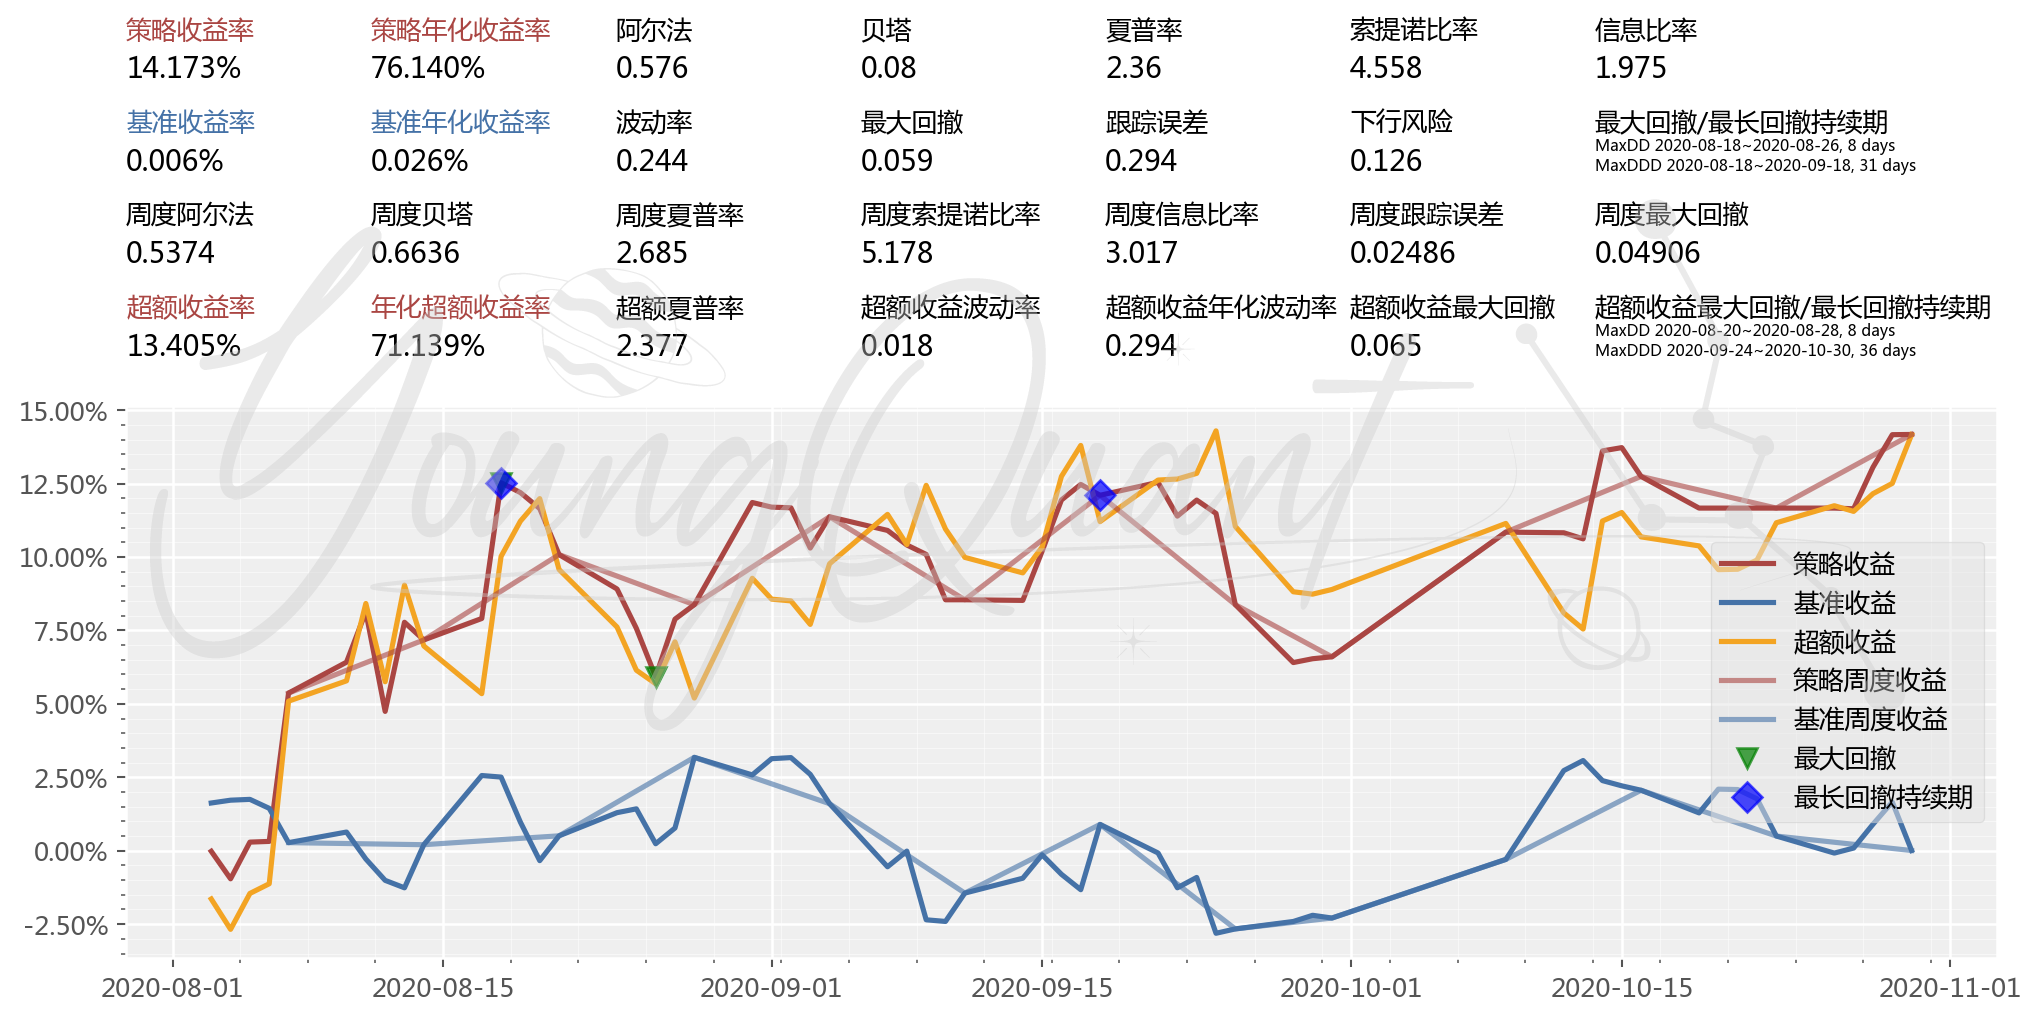

In [3]:
def init(context):
    context.observation = 30  # 观测期
    context.topM = 100  # 每个指标选前M只股票
    context.topN = 20  # 最终排名前N只股票
    scheduler.run_monthly(find_order_stocks, tradingday=1, time_rule='before_trading')
    scheduler.run_monthly(sink_stock, tradingday=1, time_rule=market_open(hour=0))
    context.bought={}
    global mark
    mark = {}
def handle_bar(context,bar_dict):
    stock_vo_ra={}
    indicators = ['open','high','low','close','volume']
    start_time = (context.now - datetime.timedelta(days=context.observation)).strftime("%Y%m%d")
    start_time_long = (context.now -  datetime.timedelta(days=context.observation + 330)).strftime("%Y%m%d")  #观测器为1年，保证能取到到年报中数据
    end_time = context.now.strftime("%Y%m%d")
    #print(context.yq_order_stocks)
    for ts_code in context.yq_order_stocks:
        yq_code = ts_code.replace('XSHG','SH').replace('XSHE','SZ')
        volume_ra = yq.basic.daily_basic(ts_code=yq_code, start_date=end_time, end_date=end_time, fields='volume_ratio')
        # print(volume_ra)
        ts_code_open = history_bars(ts_code , 20 , '1d' ,  indicators[0])
        ts_code_high = history_bars(ts_code , 3 , '1d' ,  indicators[1])
        ts_code_low = history_bars(ts_code , 3 , '1d' ,  indicators[2])
        ts_code_close = history_bars(ts_code , 20 , '1d' ,  indicators[3])
        ts_code_volume = history_bars(ts_code , 20 , '1d' ,  indicators[4])
        #当天开盘涨跌幅绝对值小于5%
        try:
            if ts_code_open[-1] / ts_code_close[-2]-1 < 0.035 and ts_code_open[-1] / ts_code_close[-2]-1 > -0.025 and volume_ra['volume_ratio'][0] > 2.5:
                for i in range(14):
                  #前N天内有高成交量阳线
                    if ( ts_code_close[-i-1] / ts_code_open[-i-1]-1 > 0.04 ) and ts_code_volume[-i-1] * ts_code_close[-i-1] > 2000000 :
                        if ts_code_close[-1] >ts_code_high[-2]:
                            order_target_percent(ts_code , 0.25)
                            context.bought[ts_code] = 1 
                            mark[ts_code] = [ts_code_low[-1],ts_code_volume[-1]]
                            #print(context.bought)
        except:
            print(ts_code)
    # 卖出择时
    temp_bought={}
    for ts_code in context.bought.keys():
        temp_bought[ts_code] = 1
        ts_code_open = history_bars(ts_code , 20 , '1d' ,  indicators[0])
        ts_code_high = history_bars(ts_code , 3 , '1d' ,  indicators[1])
        ts_code_low = history_bars(ts_code , 3 , '1d' ,  indicators[2])
        ts_code_close = history_bars(ts_code , 20 , '1d' ,  indicators[3])
        ts_code_volume = history_bars(ts_code , 20 , '1d' ,  indicators[4])
        temp_bought[ts_code] = 1 
        if (ts_code_high[-1] > ts_code_high[-2] or ts_code_volume[-1] >ts_code_volume[-2]) and ts_code_low[-1] >ts_code_low[-2]:
            mark[ts_code] = [ts_code_low[-1],ts_code_volume[-1]]
        if ts_code_close[-1] < max (ts_code_low[-2] , mark[ts_code][0]) :
            order_target_percent(ts_code,0)
            del temp_bought[ts_code]
    context.bought = temp_bought
results=run_func(init=init,handle_bar=handle_bar, config=config)